In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
from tqdm import tqdm

from multiprocessing import Pool

loops = 500000

---
### genereate

In [2]:
def itpc_cmplx(cmplx):
    _unit = np.sum(cmplx / np.abs(cmplx)) / np.size(cmplx)
    return _unit

def _step(ni):
    _temp = []
    for li in range(loops):
        sample = np.random.randn(ni) + 1j * np.random.randn(ni)

        _itpc = itpc_cmplx(sample)
        _temp.append(np.abs(_itpc))
    
    return np.mean(_temp), np.std(_temp), ni

In [8]:
## %%time
_itpc_mu = []
_itpc_sig = []
for i in tqdm(range(1, 200)):
    a,b,_ = _step(i)
    _itpc_mu.append(a)
    _itpc_sig.append(b)

100%|██████████| 199/199 [44:54<00:00, 20.37s/it]


In [3]:
with Pool(processes=10) as p:
    start = 1
    length = 199
    k = list(tqdm(p.imap_unordered(_step, range(start, start+length)), total=length))
    
_itpc_ch = np.array(k)[:, 2]
_order = np.argsort(_itpc_ch)
_itpc_mu = np.array(k)[_order, 0]
_itpc_sig = np.array(k)[_order, 1]

100%|██████████| 199/199 [07:48<00:00,  3.11s/it]


In [5]:
np.save("ITPC_thresh.npy", [_itpc_mu, _itpc_sig])

---
### restore

In [6]:
_itpc_mu, _itpc_sig = np.load('ITPC_thresh.npy')
loops = 1
length = 199

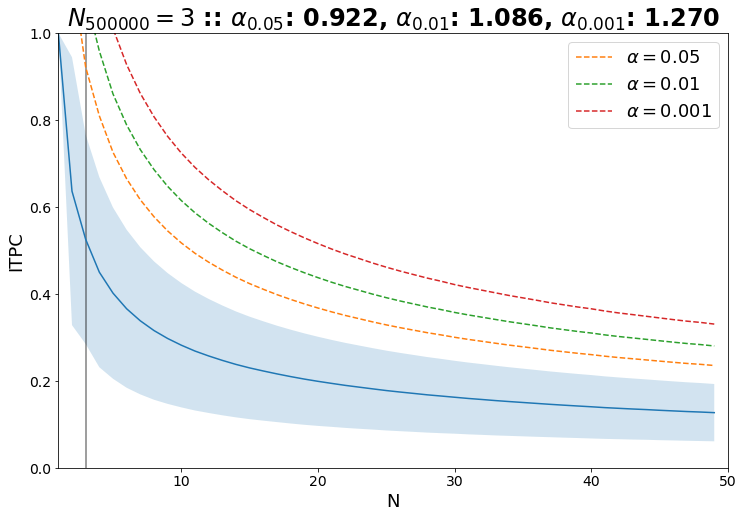

In [10]:
selected_n = 2

body_font_size = 18
title_font_size = 24
tick_font_size = 14



plt.figure(figsize=(12,8))
plt.plot(range(1,length+1), _itpc_mu)
plt.fill_between(range(1,length+1), _itpc_mu-_itpc_sig, _itpc_mu+_itpc_sig, alpha=0.2)

plt.plot(range(1,length+1), _itpc_mu+stats.norm(0,1).ppf(0.95)*_itpc_sig, '--',  label="$\\alpha=0.05$")
plt.plot(range(1,length+1), _itpc_mu+stats.norm(0,1).ppf(0.99)*_itpc_sig, '--',  label="$\\alpha=0.01$")
plt.plot(range(1,length+1), _itpc_mu+stats.norm(0,1).ppf(0.999)*_itpc_sig, '--', label="$\\alpha=0.001$")

plt.vlines(selected_n+1, 0, 1, alpha=0.5, color="black")

plt.title("$N_{%d} = %d$ :: $\\alpha_{0.05}$: %.3f, $\\alpha_{0.01}$: %.3f, $\\alpha_{0.001}$: %.3f"%(
    loops,
    selected_n+1,
    _itpc_mu[selected_n] + stats.norm(0,1).ppf(0.95)*_itpc_sig[selected_n],
    _itpc_mu[selected_n] + stats.norm(0,1).ppf(0.99)*_itpc_sig[selected_n],
    _itpc_mu[selected_n] + stats.norm(0,1).ppf(0.999)*_itpc_sig[selected_n],
    ), fontsize=title_font_size, fontweight='bold')

plt.legend(fontsize=body_font_size)
plt.xticks(fontsize=tick_font_size)
plt.yticks(fontsize=tick_font_size)
plt.ylim((0,1))
plt.xlim((1,length+1))
plt.xlabel("N", fontsize=body_font_size)
plt.ylabel("ITPC", fontsize=body_font_size)
plt.show()
# plt.tight_layout()
# plt.savefig("ITPC_thresh.png", bbox_inches='tight')
plt.close()